In [44]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(digest)
library(repr)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)

## Outline

1. read data, select "Post Hour" and "Likes", "Comments", "Shares"
2. split data
3. create knn regression model
        - find best k in workflow using training data
        - refit the model with test data
4. create simple linear regression model
5. create new tibble with every hour
6. find "Likes", "Comments", "Shares" for each hour using knn regression and linear regression models
7. find hour with highest "Likes", "Comments", "Shares"

When is the best month, weekday, and hour to post for the highest engagement in comments, likes, and shares?

In [48]:
#reading the data
temp <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip",temp)

#Reading the data in R
facebook <- read_csv2(unz(temp, "dataset_Facebook.csv"))
head(facebook)
unlink(temp)
facebook

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.

Parsed with column specification:
cols(
  `Page total likes` = col_double(),
  Type = col_character(),
  Category = col_double(),
  `Post Month` = col_double(),
  `Post Weekday` = col_double(),
  `Post Hour` = col_double(),
  Paid = col_double(),
  `Lifetime Post Total Reach` = col_double(),
  `Lifetime Post Total Impressions` = col_double(),
  `Lifetime Engaged Users` = col_double(),
  `Lifetime Post Consumers` = col_double(),
  `Lifetime Post Consumptions` = col_double(),
  `Lifetime Post Impressions by people who have liked your Page` = col_double(),
  `Lifetime Post reach by people who like your Page` = col_double(),
  `Lifetime People who have liked your Page and engaged with your post` = col_double(),
  comment = col_double(),
  like = col_double(),
  share = col_double(),
  `Total Interactions` = col_double()
)



Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
139441,Photo,2,12,4,3,0,2752,5091,178,109,159,3078,1640,119,4,79,17,100
139441,Status,2,12,3,10,0,10460,19057,1457,1361,1674,11710,6112,1108,5,130,29,164
139441,Photo,3,12,3,3,0,2413,4373,177,113,154,2812,1503,132,0,66,14,80
139441,Photo,2,12,2,10,1,50128,87991,2211,790,1119,61027,32048,1386,58,1572,147,1777
139441,Photo,2,12,2,3,0,7244,13594,671,410,580,6228,3200,396,19,325,49,393
139441,Status,2,12,1,9,0,10472,20849,1191,1073,1389,16034,7852,1016,1,152,33,186


Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
139441,Photo,2,12,4,3,0,2752,5091,178,109,159,3078,1640,119,4,79,17,100
139441,Status,2,12,3,10,0,10460,19057,1457,1361,1674,11710,6112,1108,5,130,29,164
139441,Photo,3,12,3,3,0,2413,4373,177,113,154,2812,1503,132,0,66,14,80
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
81370,Photo,1,1,5,2,0,3778,7216,625,572,795,4742,2388,363,4,93,18,115
81370,Photo,3,1,4,11,0,4156,7564,626,574,832,4534,2452,370,7,91,38,136
81370,Photo,2,1,4,4,NA,4188,7292,564,524,743,3861,2200,316,0,91,28,119


Looking at our dataset, it passes the test for tidy data (each row is a single observation, each column is a single variable, each value is a single cell), so no further cleaning data tools are required. However, the column names are separated by white spaces instead of underscores (_). We will deal with this issue first and rename our predictor columns to additional headaches along the way. 

Before we'll get ahead with our exploratory data analysis, we'll split the data into training and testing data to perform a quick summary of the dataset, including the number of rows, the number of columns, the number of rows with missing data values, and the mean of our predictor variables.

In [64]:
#Renaming "Post Hour"
facebook_1 <- facebook %>% rename(post_hour = `Post Hour`) 

#Split into training (75 percent of data set) and test data
set.seed(2021)
facebook_split <- initial_split(facebook_1, prop = 0.75, strata = post_hour)
facebook_train <- training(facebook_split)
facebook_test <- testing(facebook_split)
facebook_train

#Missing Rows of Data
missing_rows <- sum(colSums(is.na(facebook_train)))

#fill in blank values with 0
facebook_train[is.na(facebook_train)] <- 0

#Average of Each Predictor Variable
average_likes <- mean(facebook_train[["like"]])
average_comments <- mean(facebook_train[["comment"]])
average_shares <- mean(facebook_train[["share"]])

#Total Number of Observations
observation_total <- nrow(facebook_train)

#Total Number of Variables
variable_total <- ncol(facebook_train)

#Exploratory Data Analysis Table
exploratory_table <- facebook_train %>%
                     mutate(facebook_train, observation_total = observation_total) %>%
                     mutate(facebook_train, variable_total = variable_total) %>%
                     mutate(facebook_train, average_likes = average_likes) %>%
                     mutate(facebook_train, average_comments = average_comments) %>%
                     mutate(facebook_train, average_shares = average_shares) %>%
                     mutate(facebook_train, missing_rows = missing_rows) %>%
                     select(observation_total, variable_total, average_likes, average_comments, average_shares, missing_rows) %>%
                     slice(1)
exploratory_table
#facebook <- facebook %>% 
  #  select("Post Hour", "like", "comment", "share") %>% 
   # rename(post_hour = "Post Hour")
#facebook

#fill in blank values with 0
facebook[is.na(facebook)] <- 0

Page total likes,Type,Category,Post Month,Post Weekday,post_hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
139441,Photo,2,12,4,3,0,2752,5091,178,109,159,3078,1640,119,4,79,17,100
139441,Photo,3,12,3,3,0,2413,4373,177,113,154,2812,1503,132,0,66,14,80
139441,Photo,2,12,2,10,1,50128,87991,2211,790,1119,61027,32048,1386,58,1572,147,1777
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
85093,Photo,3,1,7,2,0,4684,7536,733,708,985,4750,2876,392,5,53,26,84
81370,Photo,1,1,5,2,0,3778,7216,625,572,795,4742,2388,363,4,93,18,115
81370,Photo,3,1,4,11,0,4156,7564,626,574,832,4534,2452,370,7,91,38,136


observation_total,variable_total,average_likes,average_comments,average_shares,missing_rows
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
377,19,188.3289,8.007958,28.06897,0


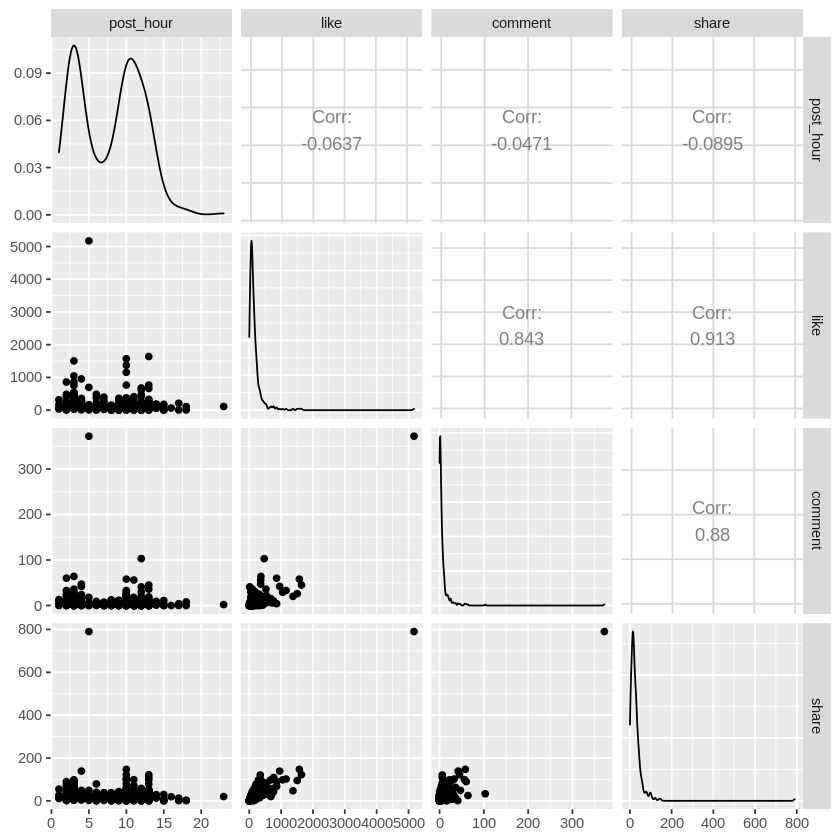

In [58]:
#Ggpairs
facebook_ggpairs <- facebook_train %>%
                    select(post_hour, like, comment, share) %>%
                    ggpairs()
facebook_ggpairs

## Predicting Best Post Hour

In [5]:
#Recipe for Post Hour
facebook_recipe <- recipe(post_hour ~ comment + share + like, data = facebook_train) %>%
                   step_scale(all_predictors()) %>%
                   step_center(all_predictors())
#Model
facebook_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
                 set_engine("kknn") %>%
                 set_mode("regression")

#5 fold cross validation
facebook_vfold <- vfold_cv(facebook_train, v = 5, strata = post_hour)

#workflow
facebook_workflow <- workflow() %>%
                     add_recipe(facebook_recipe) %>%
                     add_model(facebook_spec)

#testing 200 values to find the best value for K
gridvals <- tibble(neighbors = seq(1, 200))

#Tuning workflow to test the values of K
facebook_results <- facebook_workflow %>%
                        tune_grid(resamples = facebook_vfold, grid = gridvals) %>%
                        collect_metrics()
#Min amount of RMSPE along with mean and standard error to find the best K value to use
facebook_min <- facebook_results %>%
    filter(.metric == "rmse") %>%
    arrange(mean)  %>% 
    slice(1)

facebook_min

#Min RMSPE
k_min <- facebook_min %>%
            pull(neighbors)

#Using the best K in our model
facebook_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
                            set_engine("kknn") %>%
                            set_mode("regression")

#Reworking the workflow to incorporate our chosen K
facebook_best_fit <- workflow() %>%
                        add_recipe(facebook_recipe) %>%
                        add_model(facebook_best_spec) %>%
                        fit(data = facebook_train)

#Summary of the training vs testing data
facebook_summary <- facebook_best_fit %>% 
                       predict(facebook_test) %>%
                       bind_cols(facebook_test) %>%
                       metrics(truth = post_hour, estimate = .pred) 

facebook_summary

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
55,rmse,standard,4.311845,5,0.1005771,Model055


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,4.32360270
rsq,standard,0.02240057
mae,standard,3.88810052


In [6]:
fb_spec <- linear_reg() %>%
    set_engine("lm") %>%
    set_mode("regression")

fb_recipe <- recipe(post_hour ~ comment + share + like, data = facebook_train)

fb_fit <- workflow() %>%
    add_recipe(fb_recipe) %>%
    add_model(fb_spec) %>%
    fit(data = facebook_train)

fb_test_results <- fb_fit %>%
    predict(facebook_test) %>%
    bind_cols(facebook_test) %>%
    metrics(truth = post_hour, estimate = .pred)
fb_test_results



.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,4.357858612
rsq,standard,0.005157872
mae,standard,3.937141926
